In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# SVM


In [ ]:
# Importations nécessaires
import numpy as np
from sklearn.svm import SVR  # Régression SVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

# Étape 1 : Charger le dataset
dataset = load_dataset("mteb/stsbenchmark-sts")
train_data = dataset['train']
test_data = dataset['test']

# Extraire les phrases et scores
train_sentence1 = train_data['sentence1']
train_sentence2 = train_data['sentence2']
train_scores = np.array(train_data['score'])  # Scores de similarité pour l'entraînement

test_sentence1 = test_data['sentence1']
test_sentence2 = test_data['sentence2']
test_scores = np.array(test_data['score'])  # Scores de similarité pour le test

# Étape 2 : Encoder les phrases en vecteurs avec SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # Modèle rapide et précis

# Générer les embeddings pour chaque ensemble
train_embeddings1 = model.encode(train_sentence1, convert_to_tensor=False)
train_embeddings2 = model.encode(train_sentence2, convert_to_tensor=False)
test_embeddings1 = model.encode(test_sentence1, convert_to_tensor=False)
test_embeddings2 = model.encode(test_sentence2, convert_to_tensor=False)

# Calculer la différence absolue des vecteurs (caractéristique pour SVM)
train_features = np.abs(train_embeddings1 - train_embeddings2)  # Distance entre phrases
test_features = np.abs(test_embeddings1 - test_embeddings2)

# Étape 3 : Diviser les données pour la validation (optionnel)
X_train, X_val, y_train, y_val = train_test_split(train_features, train_scores, test_size=0.2, random_state=42)

# Étape 4 : Entraîner un modèle SVM
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Régression SVM avec noyau RBF
svm_model.fit(X_train, y_train)

# Étape 5 : Prédire sur les données de validation et de test
val_predictions = svm_model.predict(X_val)
test_predictions = svm_model.predict(test_features)

# Étape 6 : Calculer les métriques
# Erreur quadratique moyenne
val_mse = mean_squared_error(y_val, val_predictions)
test_mse = mean_squared_error(test_scores, test_predictions)

# Corrélation de Spearman
val_spearman_corr, _ = spearmanr(y_val, val_predictions)
test_spearman_corr, _ = spearmanr(test_scores, test_predictions)

# Résultats
print(f"MSE sur Validation : {val_mse:.4f}")
print(f"Corrélation Spearman sur Validation : {val_spearman_corr:.4f}")
print(f"MSE sur Test : {test_mse:.4f}")
print(f"Corrélation Spearman sur Test : {test_spearman_corr:.4f}")


MSE sur Validation : 0.6277
Corrélation Spearman sur Validation : 0.8181
MSE sur Test : 0.7444
Corrélation Spearman sur Test : 0.8141


In [ ]:
! pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 59.0 MB/s eta 0:00:00


# **Sentence-BERT**

In [ ]:
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset

# 1. Charger le modèle Sentence-BERT (all-MiniLM-L6-v2)
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Charger le dataset STS Benchmark
print("Chargement du dataset...")
dataset = load_dataset("mteb/stsbenchmark-sts", split="test")

# 3. Fonction pour calculer la similarité entre deux phrases
def calculate_similarity(sentence1, sentence2, model):
    """
    Calcule la similarité cosinus entre deux phrases en utilisant Sentence-BERT.
    """
    # Encoder les deux phrases
    embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)
    embedding1, embedding2 = embeddings[0], embeddings[1]

    # Calculer la similarité cosinus
    similarity = util.cos_sim(embedding1, embedding2).item()
    return similarity

# 4. Calcul des similarités pour un sous-ensemble du dataset
print("Calcul de la similarité textuelle...")
predicted_similarities = []
true_scores = []

# Traiter les 100 premières paires d'exemples pour l'exemple
for example in dataset.select(range(100)):
    sentence1 = example["sentence1"]
    sentence2 = example["sentence2"]
    true_score = example["score"]  # Le score de similarité annoté (0 à 5)

    # Calculer la similarité prédite
    predicted_similarity = calculate_similarity(sentence1, sentence2, model)

    # Normaliser la similarité (de [0, 1] à [0, 5])
    predicted_similarity = predicted_similarity * 5

    predicted_similarities.append(predicted_similarity)
    true_scores.append(true_score)

# 5. Afficher quelques résultats
print("\nExemple de similarités prédictes vs annotées :")
for i in range(5):
    print(f"Paire {i+1}:")
    print(f" - Similarité prédite : {predicted_similarities[i]:.2f}")
    print(f" - Similarité annotée : {true_scores[i]:.2f}")

# 6. Évaluation globale avec la corrélation de Pearson
from scipy.stats import pearsonr

correlation, _ = pearsonr(predicted_similarities, true_scores)
print(f"\nCorrélation de Pearson entre les similarités prédictes et annotées : {correlation:.4f}")


Chargement du dataset...
Calcul de la similarité textuelle...

Exemple de similarités prédictes vs annotées :
Paire 1:
 - Similarité prédite : 4.03
 - Similarité annotée : 2.50
Paire 2:
 - Similarité prédite : 3.94
 - Similarité annotée : 3.60
Paire 3:
 - Similarité prédite : 4.73
 - Similarité annotée : 5.00
Paire 4:
 - Similarité prédite : 4.41
 - Similarité annotée : 4.20
Paire 5:
 - Similarité prédite : 1.78
 - Similarité annotée : 1.50

Corrélation de Pearson entre les similarités prédictes et annotées : 0.9110


In [ ]:
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset

# 1. Charger le modèle Sentence-BERT (all-MiniLM-L6-v2)
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Charger le dataset STS Benchmark
print("Chargement du dataset...")
dataset = load_dataset("mteb/stsbenchmark-sts", split="test")

# 3. Fonction pour calculer la similarité entre deux phrases
def calculate_similarity(sentence1, sentence2, model):
    """
    Calcule la similarité cosinus entre deux phrases en utilisant Sentence-BERT.
    """
    # Encoder les deux phrases
    embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)
    embedding1, embedding2 = embeddings[0], embeddings[1]

    # Calculer la similarité cosinus
    similarity = util.cos_sim(embedding1, embedding2).item()
    return similarity

# 4. Recherche des 5 phrases les plus similaires à une phrase donnée
def find_top_similar_sentences(input_sentence, dataset, model, top_n=5):
    """
    Trouve les top_n phrases les plus similaires à l'input_sentence dans le dataset.
    """
    # Encoder la phrase d'entrée
    input_embedding = model.encode(input_sentence, convert_to_tensor=True)

    # Liste pour stocker les similarités et les phrases
    similarities = []

    # Calculer la similarité de la phrase d'entrée avec chaque phrase du dataset
    for example in dataset:
        sentence = example['sentence1']  # Utiliser sentence1 pour la comparaison
        similarity = calculate_similarity(input_sentence, sentence, model)
        similarities.append((sentence, similarity))

    # Trier les phrases par similarité décroissante
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Retourner les top_n phrases les plus similaires
    return similarities[:top_n]

# 5. Demander à l'utilisateur d'entrer une phrase
input_sentence = input("Entrez une phrase pour trouver les 5 phrases les plus similaires : ")

# 6. Trouver et afficher les 5 phrases les plus similaires
top_similar_sentences = find_top_similar_sentences(input_sentence, dataset, model)

print("\nLes 5 phrases les plus similaires à votre entrée sont :")
for idx, (sentence, similarity) in enumerate(top_similar_sentences, 1):
    print(f"{idx}. {sentence} (similarité : {similarity:.4f})")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Chargement du dataset...


README.md:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Entrez une phrase pour trouver les 5 phrases les plus similaires : A person is playing a musical instrument

Les 5 phrases les plus similaires à votre entrée sont :
1. A person is playing a piano. (similarité : 0.7312)
2. A man plays a guitar. (similarité : 0.7006)
3. Someone is playing a piano. (similarité : 0.6983)
4. A man is playing a guitar. (similarité : 0.6930)
5. A man is playing a guitar. (similarité : 0.6930)


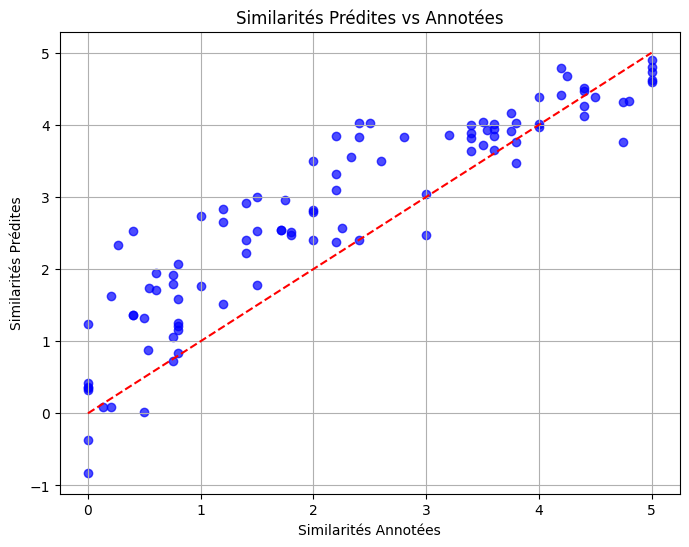

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(true_scores, predicted_similarities, alpha=0.7, color='blue')
plt.plot([0, 5], [0, 5], '--', color='red')  # Diagonale parfaite
plt.title("Similarités Prédites vs Annotées")
plt.xlabel("Similarités Annotées")
plt.ylabel("Similarités Prédites")
plt.grid()
plt.show()


In [ ]:
! pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 61.7 MB/s eta 0:00:00


# **FAISS**

In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from scipy.stats import spearmanr, pearsonr

# Charger le dataset
dataset = load_dataset("mteb/stsbenchmark-sts", split="train")

# Initialiser le modèle SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encoder les phrases en embeddings
sentences1 = dataset['sentence1']
sentences2 = dataset['sentence2']

embeddings1 = model.encode(sentences1, show_progress_bar=True, convert_to_numpy=True)
embeddings2 = model.encode(sentences2, show_progress_bar=True, convert_to_numpy=True)

# Convertir les embeddings en tableau numpy (FAISS attend un tableau numpy)
embeddings1 = embeddings1.astype('float32')
embeddings2 = embeddings2.astype('float32')

# Créer l'index HNSW FAISS
dimension = embeddings1.shape[1]  # dimension des embeddings
index = faiss.IndexHNSWFlat(dimension, 32)  # 32 est le nombre de voisins à explorer dans chaque niveau

# Ajouter les embeddings dans l'index
index.add(embeddings1)

# Effectuer la recherche pour chaque phrase de 'sentence2' dans l'index basé sur 'sentence1'
D, I = index.search(embeddings2, k=1)  # k=1 pour la recherche du plus proche voisin

# Extraire les scores de similarité réels depuis le dataset (la colonne correcte est 'score')
real_similarities = dataset['score']  # Score de similarité réel entre les paires

# Calculer la similarité entre les prédictions FAISS (D) et les scores réels
predicted_similarities = 1 / (1 + D[:, 0])  # Convertir la distance en similarité

# Calculer la corrélation de Pearson et Spearman
pearson_corr, _ = pearsonr(predicted_similarities, real_similarities)
spearman_corr, _ = spearmanr(predicted_similarities, real_similarities)

# Afficher les résultats
print(f"Corrélation de Pearson : {pearson_corr:.4f}")
print(f"Corrélation de Spearman : {spearman_corr:.4f}")


Batches:   0%|          | 0/180 [00:00<?, ?it/s]

Batches:   0%|          | 0/180 [00:00<?, ?it/s]

Corrélation de Pearson : 0.3945
Corrélation de Spearman : 0.4355


In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

# Charger le dataset
dataset = load_dataset("mteb/stsbenchmark-sts", split="train")

# Initialiser le modèle SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encoder les phrases du dataset en embeddings
sentences1 = dataset['sentence1']
sentences2 = dataset['sentence2']

embeddings1 = model.encode(sentences1, show_progress_bar=True, convert_to_numpy=True)
embeddings2 = model.encode(sentences2, show_progress_bar=True, convert_to_numpy=True)

# Convertir les embeddings en tableau numpy (FAISS attend un tableau numpy)
embeddings1 = embeddings1.astype('float32')
embeddings2 = embeddings2.astype('float32')

# Créer l'index HNSW FAISS
dimension = embeddings1.shape[1]  # dimension des embeddings
index = faiss.IndexHNSWFlat(dimension, 32)  # 32 est le nombre de voisins à explorer dans chaque niveau

# Ajouter les embeddings dans l'index
index.add(embeddings1)

# Demander à l'utilisateur de saisir une phrase pour la recherche
input_sentence = input("Entrez une phrase pour trouver les 5 phrases les plus similaires : ")

# Encoder l'entrée de l'utilisateur en embedding
input_embedding = model.encode([input_sentence], convert_to_numpy=True).astype('float32')

# Effectuer la recherche pour cette entrée dans l'index et obtenir les 5 phrases les plus similaires
D, I = index.search(input_embedding, k=5)  # k=5 pour trouver les 5 voisins les plus proches

# Afficher les résultats : les 5 phrases les plus similaires et leurs distances
print("\nLes 5 phrases les plus similaires à votre entrée sont :")
for i in range(5):
    print(f"{i+1}. {dataset['sentence1'][I[0][i]]} (Score de similarité : {1 / (1 + D[0][i]):.4f})")


Batches:   0%|          | 0/180 [00:00<?, ?it/s]

Batches:   0%|          | 0/180 [00:00<?, ?it/s]

Entrez une phrase pour trouver les 5 phrases les plus similaires : The weather is beautiful today, perfect for a walk in the park

Les 5 phrases les plus similaires à votre entrée sont :
1. Feet standing on a pretty day with large building in background. (Score de similarité : 0.4398)
2. Hey, Blue-Eyes, How's things in London? (Score de similarité : 0.4368)
3. The weather service reported maximum sustained winds of nearly 105 miles an hour with stronger gusts. (Score de similarité : 0.4359)
4. A man is walking outside. (Score de similarité : 0.4268)
5. A man is walking along a path through wilderness. (Score de similarité : 0.4263)


# EDA

In [ ]:
from datasets import load_dataset

dataset = load_dataset("mteb/stsbenchmark-sts", split="train")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Dataset({
    features: ['split', 'genre', 'dataset', 'year', 'sid', 'score', 'sentence1', 'sentence2'],
    num_rows: 5749
})

In [ ]:
import pandas as pd

# Convertir le dataset Hugging Face en DataFrame pandas
df = pd.DataFrame(dataset)

# Aperçu des premières lignes
print(df.head())

# Informations sur les colonnes et les types de données
print(df.info())

# Vérification des valeurs manquantes
print(df.isnull().sum())


   split          genre dataset      year   sid  score  \
0  train  main-captions  MSRvid  2012test  0001   5.00   
1  train  main-captions  MSRvid  2012test  0004   3.80   
2  train  main-captions  MSRvid  2012test  0005   3.80   
3  train  main-captions  MSRvid  2012test  0006   2.60   
4  train  main-captions  MSRvid  2012test  0009   4.25   

                                       sentence1  \
0                         A plane is taking off.   
1                A man is playing a large flute.   
2  A man is spreading shreded cheese on a pizza.   
3                   Three men are playing chess.   
4                    A man is playing the cello.   

                                           sentence2  
0                        An air plane is taking off.  
1                          A man is playing a flute.  
2  A man is spreading shredded cheese on an uncoo...  
3                         Two men are playing chess.  
4                 A man seated is playing the cello.  
<class '

count    5749.000000
mean        2.700999
std         1.464398
min         0.000000
25%         1.500000
50%         3.000000
75%         3.800000
max         5.000000
Name: score, dtype: float64


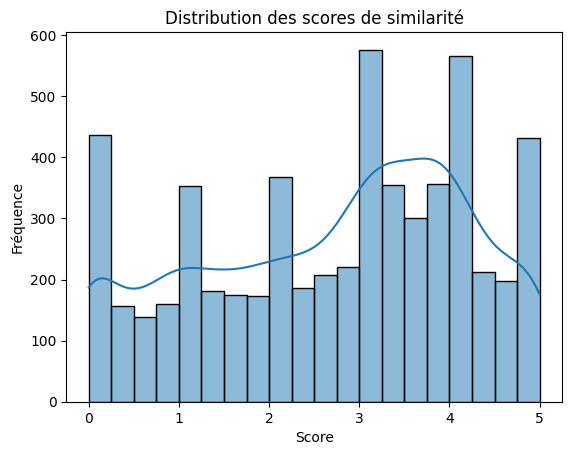

In [ ]:
# Statistiques descriptives
print(df['score'].describe())

# Visualiser la distribution des scores
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['score'], bins=20, kde=True)
plt.title("Distribution des scores de similarité")
plt.xlabel("Score")
plt.ylabel("Fréquence")
plt.show()


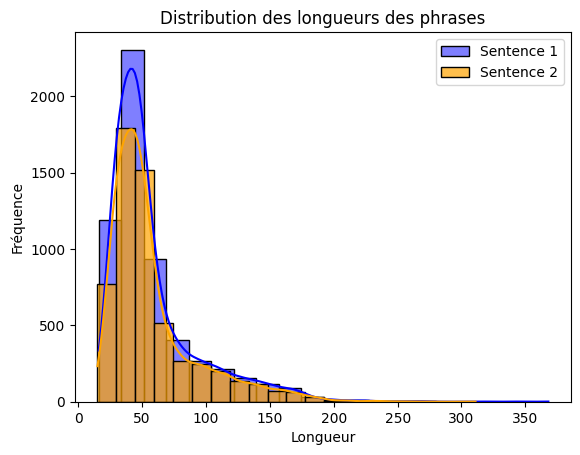

In [ ]:
# Distribution des longueurs des phrases
sns.histplot(df['length_sentence1'], bins=20, kde=True, color="blue", label="Sentence 1")
sns.histplot(df['length_sentence2'], bins=20, kde=True, color="orange", label="Sentence 2", alpha=0.7)
plt.title("Distribution des longueurs des phrases")
plt.xlabel("Longueur")
plt.ylabel("Fréquence")
plt.legend()
plt.show()


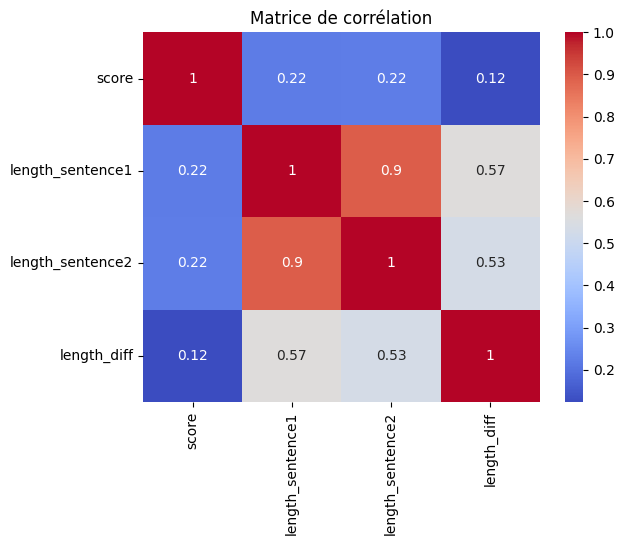

In [ ]:
# Longueur des phrases
df['length_sentence1'] = df['sentence1'].apply(len)
df['length_sentence2'] = df['sentence2'].apply(len)
# Différence absolue entre les longueurs des deux phrases
df['length_diff'] = abs(df['length_sentence1'] - df['length_sentence2'])
correlation_matrix = df[['score', 'length_sentence1', 'length_sentence2', 'length_diff']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

**Interprétation** :
La longueur des phrases (ou leur différence) a un impact faible sur le score de similarité. Cela suggère que le score de similarité est probablement davantage influencé par le contenu sémantique des phrases plutôt que leur longueur

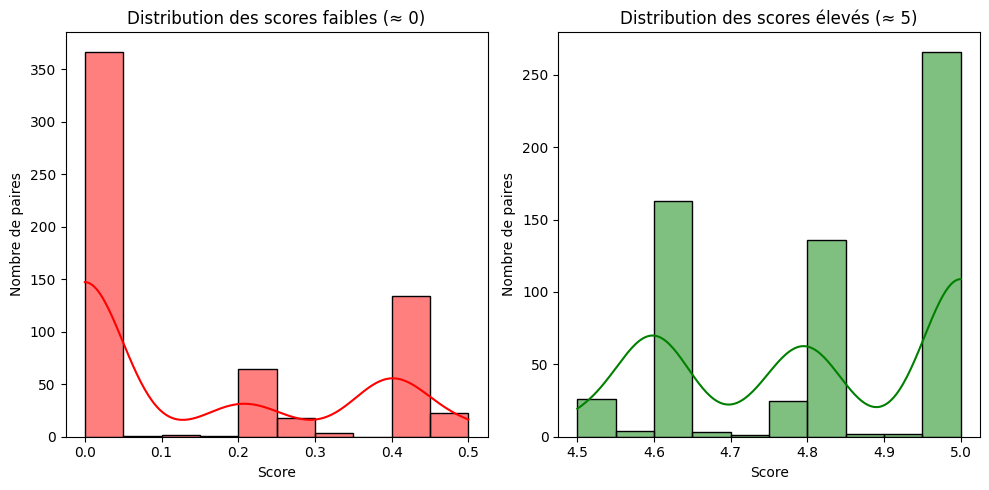

In [ ]:
low_score_threshold = 0.5
high_score_threshold = 4.5

low_score_sentences = df[df['score'] <= low_score_threshold]
high_score_sentences = df[df['score'] >= high_score_threshold]
# Visualiser la distribution des scores extrêmes
plt.figure(figsize=(10, 5))

# Histogramme pour faible similarité
plt.subplot(1, 2, 1)
sns.histplot(low_score_sentences['score'], bins=10, kde=True, color='red')
plt.title("Distribution des scores faibles (≈ 0)")
plt.xlabel("Score")
plt.ylabel("Nombre de paires")

# Histogramme pour forte similarité
plt.subplot(1, 2, 2)
sns.histplot(high_score_sentences['score'], bins=10, kde=True, color='green')
plt.title("Distribution des scores élevés (≈ 5)")
plt.xlabel("Score")
plt.ylabel("Nombre de paires")

plt.tight_layout()
plt.show()


In [ ]:
# Statistiques sur la longueur des phrases dans les deux catégories
print("Statistiques pour les phrases à faible similarité :")
print(low_score_sentences[['length_sentence1', 'length_sentence2']].describe())

print("\nStatistiques pour les phrases à forte similarité :")
print(high_score_sentences[['length_sentence1', 'length_sentence2']].describe())


Statistiques pour les phrases à faible similarité :
       length_sentence1  length_sentence2
count        615.000000        615.000000
mean          40.544715         40.611382
std           14.194813         14.226078
min           16.000000         16.000000
25%           29.000000         29.000000
50%           39.000000         39.000000
75%           49.500000         50.000000
max          110.000000        102.000000

Statistiques pour les phrases à forte similarité :
       length_sentence1  length_sentence2
count        628.000000        628.000000
mean          57.769108         58.111465
std           35.559495         35.253880
min           16.000000         15.000000
25%           36.000000         36.000000
50%           48.000000         47.000000
75%           61.000000         63.000000
max          234.000000        227.000000


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

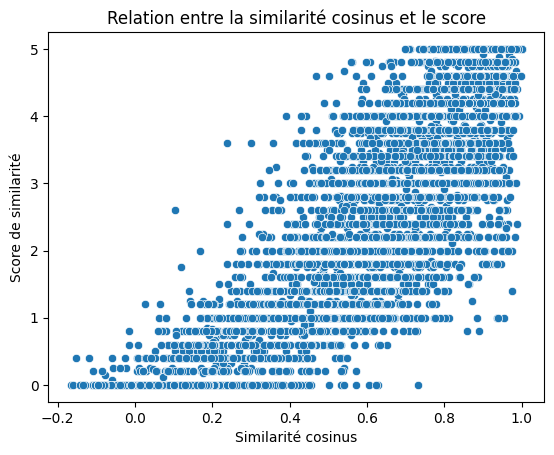

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Calculer les embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings1 = model.encode(df['sentence1'], convert_to_tensor=False)
embeddings2 = model.encode(df['sentence2'], convert_to_tensor=False)

# Similarité cosinus entre les phrases
df['cosine_similarity'] = [cosine_similarity([emb1], [emb2])[0][0] for emb1, emb2 in zip(embeddings1, embeddings2)]

# Comparer avec les scores
sns.scatterplot(x=df['cosine_similarity'], y=df['score'])
plt.title("Relation entre la similarité cosinus et le score")
plt.xlabel("Similarité cosinus")
plt.ylabel("Score de similarité")
plt.show()


In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
